# Import

In [21]:
import os
from sqlalchemy import create_engine, text as sql_text
import pandas as pd
import requests
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Connect to database

In [16]:
csv_url = 'https://drive.google.com/uc?id=1S3IP-tOAQ7lgiQsjxCv54CIEdmzKu4UT'

In [78]:
df = pd.read_csv(csv_url)

In [79]:
df

,Unnamed: 0,Date,Open,dayth,log2open,log2dayth,PredictedLog2Open,Prediction
0,1,2010-07-19,0.100000,561,-3.321928,9.131857,-2.798116,0.143775
1,2,2010-07-20,0.100000,562,-3.321928,9.134426,-2.783564,0.145233
2,3,2010-07-21,0.100000,563,-3.321928,9.136991,-2.769037,0.146702
3,4,2010-07-22,0.100000,564,-3.321928,9.139551,-2.754536,0.148184
4,5,2010-07-23,0.100000,565,-3.321928,9.142107,-2.740060,0.149679
...,...,...,...,...,...,...,...,...
5116,5117,2024-07-21,67164.914062,5677,16.035420,12.470913,16.114045,70926.905264
5117,5118,2024-07-22,68152.976562,5678,16.056489,12.471167,16.115485,70997.697882
5118,5119,2024-07-23,67584.804688,5679,16.044411,12.471421,16.116924,71068.548674
5119,5120,2024-07-24,65927.859375,5680,16.008601,12.471675,16.118362,71139.457675


# Data Process and Train

In [25]:
X = df[['log2dayth']]
y = df['log2open']
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42)

In [22]:
def modeler(X_train, X_test, y_train, y_test):
    reg = LinearRegression().fit(X_train,y_train)
    const = reg.intercept_
    score_train = reg.score(X_train,y_train)
    score_test = reg.score(X_test,y_test)
    coef = reg.coef_[0]
    return const, coef, score_train, score_test

In [26]:
const, coef, score_train, score_test = modeler(X_train, X_test, y_train, y_test)

In [31]:
print(f'const:{const}\ncoef:{coef}\nscore_test:{score_test}')

const:-54.521191291103314
coef:5.663406965362047
score_test:0.9595762758457078


# Result and Plot

In [32]:
def predictor(const, coef, x):
    y = const + coef * x
    return y

In [34]:
pd.options.plotting.backend = "plotly"

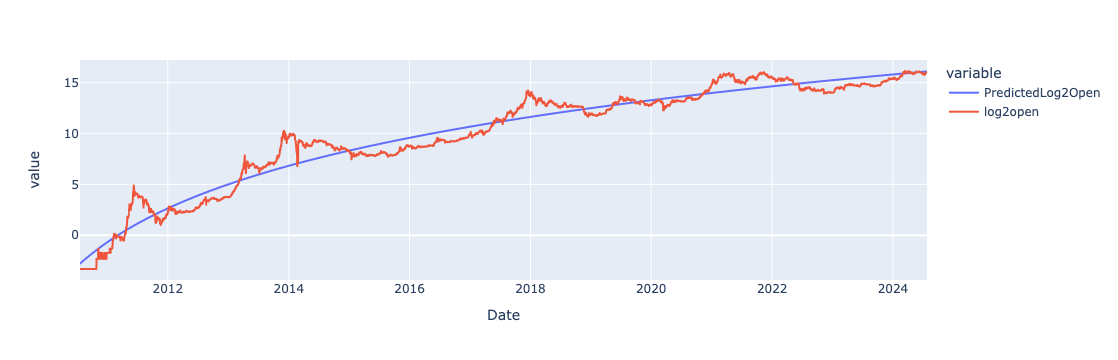

In [37]:
df.plot(kind='line', x='Date', y=['PredictedLog2Open','log2open'])

# how to get btc prices

In [38]:
import yfinance as yf

# Fetch BTC/USD data
btc_data = yf.Ticker("BTC-USD")

# Get the latest day's data
latest_data = btc_data.history(period="1d")

# Extract the open price
latest_open_price = latest_data['Open'].iloc[0]

print(f"Latest Day Open Price of BTC/USD: {latest_open_price}")

Latest Day Open Price of BTC/USD: 58204.09375


In [39]:
latest_date = latest_data.index[0].date()
latest_date

datetime.date(2024, 9, 17)

In [69]:
import numpy as np

In [99]:
def df_maker(const, coef, start, ticker='BTC-USD'):
    data = yf.Ticker(ticker).history(start=start)
    df = pd.DataFrame(data)
    df.reset_index(inplace=True)  # Reset index to make Date a column
    df['Date'] = df['Date'].dt.date  # Convert Date to date type (removing time)
    df['Date'] = df['Date'].astype(str)
    df = df[['Date', 'Open']]
    # Ensure Date is in datetime format for subtraction
    df['dayth'] = (pd.to_datetime(df['Date']) - pd.to_datetime(date(2010, 7, 19))).dt.days + 561
    df['log2open'] = np.log2(df['Open'])
    df['log2dayth'] = np.log2(df['dayth'])
    df['PredictedLog2Open'] = df['log2dayth']*coef + const
    df['Prediction'] = 2 ** df['PredictedLog2Open']
    return df

In [97]:
from datetime import datetime, date, timedelta

In [109]:
date_string = df.Date.iloc[-1] 

In [110]:
date_string

'2024-07-25'

In [101]:
date_object = datetime.strptime(date_string, '%Y-%m-%d').date()

In [105]:
start = date_object + timedelta(days=1)
df1 = df_maker(const, coef, start)